# Identifying the Sampling Frequency
By Sage Lichtenwalner, May 20, 2020

How often does the OOI sample the ocean?  The short answer is, a lot.

The sample rates for each instrument depends on its location, power availability and ultimately its science goals. Most fixed-depth instruments sample at least every 15 minutes.  But many instruments, like those on profilers or cabled platforms, sample every minute or even every second!  And in many cases, an instrument that sends back data at one resolution in real-time, may have higher resolution data available after engineers recover the raw data files.

If you want to check out the intended sample rate for a particular instrument, your best resource is the [OOI Observation and Sampling Approach](https://oceanobservatories.org/observation-and-sampling-approach/) document.  But know that things change, so to really know the rate, you should download the dataset yourself and check it out.

Luckily, thanks to my old colleague Friedrich, all you need is one line of python code to figure it out.

## First things first...
Before we can use a dataset, we first need to request and load it.  I'm just going to load some libraries and define some functions and data URLs here.  For more details on how all this works, check out the [How to Request OOI Data](https://github.com/ooi-data-lab/datalab-blog-examples/blob/master/2020/03_How_to_Request_OOI_Data.ipynb) notebook.

In [1]:
# Notebook setup
import requests
import os
import re
import xarray as xr
!pip install netcdf4
import pandas as pd
import matplotlib.pyplot as plt

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
def get_datalist(url):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets 

## Example 1: Station Papa Flanking Mooring B - CTD
First, let's take a look at the 30m CTD dataset we used in [last week's example](https://github.com/ooi-data-lab/datalab-blog-examples/blob/master/2020/04_Merging_Datasets.ipynb).  As before, we'll specify the dataset URL, then generate the list of files available, and load them.

In [0]:
data_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200512T164128069Z-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

In [0]:
data_files = get_datalist(data_url)
data = xr.open_mfdataset(data_files).swap_dims({'obs': 'time'})

And now, here are the magical lines of code.

Note, depending on how big your dataset is, this may take a while to run.

In [5]:
df = data.to_dataframe()
result = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
result

00:15:00             35100
00:15:01                 5
00:14:59                 5
-1 days +06:15:00        1
Name: time, dtype: int64

Basically, all this code is doing is taking the difference between one timestamp and the next, and then summarizing those differences with the `.value_counts()` function.

The result is an array with the time differences in the first column, and the number of times those differences were found in the second.

As we can see, for this dataset, we have 35,100 instances where the difference between one point and the next is 15 minutes exactly.  For whatever reason, the precision is off by one second for 10 rows in our dataset (5 on one side of 15 minutes, and 5 on the other).  We also found one datapoint that was over 1 day different then it's neighbor.  This is likely the datapoint where the mooring was recovered and redeployed.

We can confirm this by taking a quick look at the pressure record.

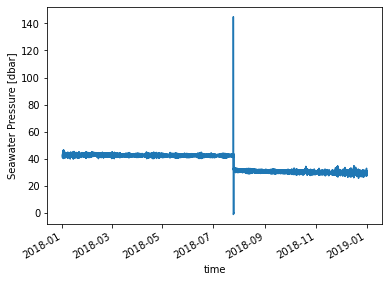

In [6]:
data.ctdmo_seawater_pressure.plot();

So, give the results above, we can safely say, that the sampling rate for this dataset is 15 minutes.

## Example 2: Pioneer Central Surface Mooring - Bulk Meteorology
Let's take a look at another dataset, using the same code as above.  

In [0]:
data_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200505T154746379Z-CP01CNSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'

In [8]:
data_files = get_datalist(data_url)
data = xr.open_mfdataset(data_files).swap_dims({'obs': 'time'})
df = data.to_dataframe()
result = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
result

00:01:04.237000    7841
00:01:04.236999    6424
00:01:04.226999    5893
00:01:04.236000    5544
00:01:04.238000    5286
                   ... 
00:01:06.831000       1
00:01:02.745000       1
00:00:35.652000       1
00:01:08.285000       1
00:01:01.423999       1
Name: time, Length: 41928, dtype: int64

So this is interesting... there are apparently almost 42,000 different intervals.  But as we can see from the first 5 rows it seems like many are around 1 minute and 4 seconds.  Here's an example where precise timing actually makes things a bit more complicated than necessary.  Suffice it to say, the Build Meteorology sensor is sampling about every minute.

## Example 3: Axial Base Shallow Profiler Mooring - CTD
Finally, let's take a look at one more instrument, this time a profiling CTD on the Cabled Array.

In [0]:
data_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200520T212720777Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'

In [12]:
data_files = get_datalist(data_url)
data = xr.open_mfdataset(data_files).swap_dims({'obs': 'time'})
df = data.to_dataframe()
result = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
result

00:00:01.000007    28275
00:00:01.000111    19208
00:00:01.000008    18736
00:00:01.000112    15989
00:00:00.999903    15981
                   ...  
00:00:01.000238        1
00:00:00.998835        1
00:00:00.997089        1
00:00:00.997505        1
00:00:00.995630        1
Name: time, Length: 5460, dtype: int64

Like the Meteorological instrument, this profiling CTD also has a lot of different timing intervals in the dataset, due to the precision in how times are recorded.  But they all seem to be centered around 1 second, which is a valid sampling rate for an instrument attached to a profiler.

Just for fun, let's plot this dataset to see what it looks like.

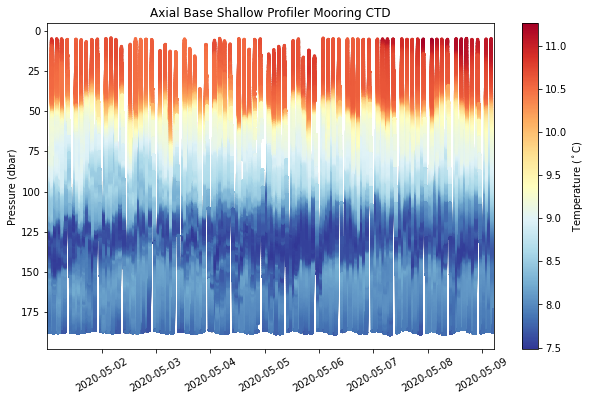

In [15]:
# Scatterplot of Temperature
fig = plt.figure(figsize=(10,6))
sc1 = plt.scatter(df.index, df.seawater_pressure, c=df.seawater_temperature, cmap='RdYlBu_r', s=5)
plt.xticks(rotation=30)
ax1 = plt.gca()
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(data.time[0],data.time[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical') # Add colorbar
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Axial Base Shallow Profiler Mooring CTD');
fig.savefig('RS03AXPS_CTD.png')